In [ ]:
!pip install geopandas shapely geopy pyproj folium contextily

In [2]:
!pip install h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00


In [3]:
# Imports
# Geometry
from h3 import h3
from shapely.geometry import Point
from shapely.geometry import Polygon
from geopy.distance import distance
from geopy.distance import geodesic
from shapely.wkt import loads


# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
import folium
from IPython.display import display
import contextily as ctx

# Projections
import pyproj
from pyproj import CRS, Transformer

# Data handling
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import ast
from pandas.io.json import json_normalize

# Network
import requests
import time

In [26]:
# Read POIs
POIS = pd.read_csv("your_path/POIS_final.csv", sep='|')
LaBota_POI = POIS[POIS['zona_estudio'] == 'LA BOTA']
LaBota_POI = LaBota_POI.dropna(subset=['category'])
toctiuco_POI = POIS[POIS['zona_estudio'] == 'TOCTIUCO']
toctiuco_POI = toctiuco_POI.dropna(subset=['category'])

In [27]:
# Shape files read and set projection
labota_shp = gpd.read_file("your_path/LaBota.shp")
if labota_shp.crs is None:
    labota_shp.crs = 'epsg:32717'
labota_shp = labota_shp.to_crs('epsg:4326')

toctiuco_shp = gpd.read_file("your_path/Toctiuco.shp")
if toctiuco_shp.crs is None:
    toctiuco_shp.crs = 'epsg:32717'
toctiuco_shp = toctiuco_shp.to_crs('epsg:4326')

In [28]:
# Extract the bounding box of the labota_shp
bbox_bota = labota_shp.total_bounds
polygon_bota = Polygon([(bbox_bota[0], bbox_bota[1]), (bbox_bota[0], bbox_bota[3]), (bbox_bota[2], bbox_bota[3]), (bbox_bota[2], bbox_bota[1])])
# Get the centroid of the bounding box
centroid_bota = polygon_bota.centroid
# Print the centroid coordinates
print(centroid_bota.x, centroid_bota.y)

-78.45956887257326 -0.11562405304648693


In [29]:
# Extract the bounding box of the labota_shp
bbox_toctiuco = toctiuco_shp.total_bounds
polygon_toctiuco = Polygon([(bbox_toctiuco[0], bbox_toctiuco[1]), (bbox_toctiuco[0], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[1])])
# Get the centroid of the bounding box
centroid_toctiuco = polygon_toctiuco.centroid
# Print the centroid coordinates
print(centroid_toctiuco.x, centroid_toctiuco.y)

-78.52568864705847 -0.20985476660321467


In [30]:
polygon1 = {
'type': 'Polygon',
'coordinates': [
[
[bbox_bota[1], bbox_bota[0]],
[bbox_bota[1], bbox_bota[2]],
[bbox_bota[3], bbox_bota[2]],
[bbox_bota[3], bbox_bota[0]],
[bbox_bota[1], bbox_bota[0]]
]
]
}

resolution = 10
hexagons1 = h3.polyfill(polygon1, resolution, geo_json_conformant=False)
hexagons1_list = list(hexagons1)

polygon2 = {
'type': 'Polygon',
'coordinates': [
[
[bbox_toctiuco[1], bbox_toctiuco[0]],
[bbox_toctiuco[1], bbox_toctiuco[2]],
[bbox_toctiuco[3], bbox_toctiuco[2]],
[bbox_toctiuco[3], bbox_toctiuco[0]],
[bbox_toctiuco[1], bbox_toctiuco[0]]
]
]
}

resolution = 10
hexagons2 = h3.polyfill(polygon2, resolution, geo_json_conformant=False)
hexagons2_list = list(hexagons2)



polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

all_polys1 = gpd.GeoSeries(list(map(polygonise, hexagons1)), \
                                      index=hexagons1, \
                                      crs="EPSG:4326" \
                                     )

all_polys2 = gpd.GeoSeries(list(map(polygonise, hexagons2)), \
                                      index=hexagons2, \
                                      crs="EPSG:4326" \
                                     )

In [33]:
# Spatial join the H3 layers and the shapefiles
all_polys1_gdf = all_polys1.to_frame()
LaBota_H3 = gpd.sjoin( all_polys1_gdf, labota_shp, predicate='intersects').reset_index()
LaBota_H3 = LaBota_H3.drop_duplicates(subset='index')
all_polys2_gdf = all_polys2.to_frame()
Toctiuco_H3 = gpd.sjoin( all_polys2_gdf, toctiuco_shp, predicate='intersects').reset_index()
Toctiuco_H3 = Toctiuco_H3.drop_duplicates(subset='index')

In [34]:
# Maps boundaries
def bounding_box_mercator(lat, lon, radius):
    # Define coordinate systems
    wgs84 = CRS("EPSG:4326")  # WGS84
    web_mercator = CRS("EPSG:3857")  # Web Mercator

    # Define transformer
    transformer = Transformer.from_crs(wgs84, web_mercator)

    # Transform lat lon to Web Mercator
    lon_mercator, lat_mercator = transformer.transform(lat, lon)

    # Add/subtract the radius from the projected point
    min_lat = lat_mercator - radius
    max_lat = lat_mercator + radius
    min_lon = lon_mercator - radius
    max_lon = lon_mercator + radius

    return min_lat, min_lon, max_lat, max_lon

# La bota
lat_centroid_bota = centroid_bota.y
lon_centroid_bota = centroid_bota.x
# Toctiuco
lat_centroid_toctiuco = centroid_toctiuco.y
lon_centroid_toctiuco = centroid_toctiuco.x
# Radius
radius = 2750  # meters

min_lat_BOTA, min_lon_BOTA, max_lat_BOTA, max_lon_BOTA = bounding_box_mercator(lat_centroid_bota, lon_centroid_bota, radius)
min_lat_TOC, min_lon_TOC, max_lat_TOC, max_lon_TOC = bounding_box_mercator(lat_centroid_toctiuco, lon_centroid_toctiuco, radius)

In [35]:
color_dict = {
    'local_economy': '#F5B700',
    'built_environment': '#04E762',
    'natural_environment': '#89FC00',
    'health': '#FC17E5',
    'government': '#2BFCF5',
    'education': '#DC0073'
}

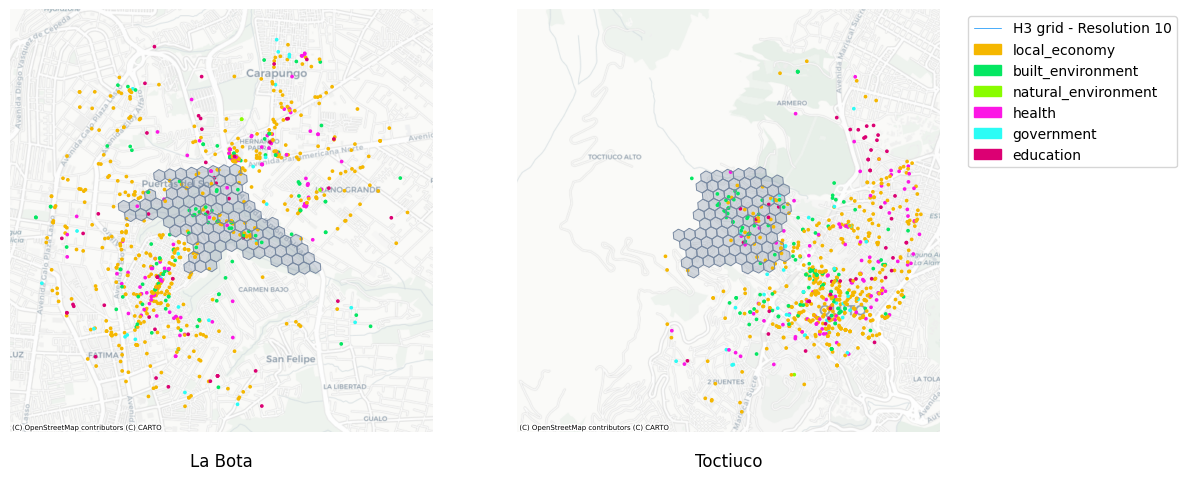

In [36]:
# Convert geodataframe to Web Mercator (epsg:3857)
LaBota_H3.crs = "EPSG:4326"
LaBota_H32 = LaBota_H3.to_crs(epsg=3857)
Toctiuco_H3.crs = "EPSG:4326"
Toctiuco_H32 = Toctiuco_H3.to_crs(epsg=3857)

# Define the transformer from WGS84 to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Create the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
ax = axs[0]

# Set the x and y axis limits
ax.set_xlim(min_lon_BOTA, max_lon_BOTA)
ax.set_ylim(min_lat_BOTA, max_lat_BOTA)

# Plot the data (only boundaries in this case)
LaBota_H32.boundary.plot(ax=ax, color='#7889A1', linewidth=0.7)
LaBota_H32.plot(ax=ax, color='#7889A1', linewidth=0.7, alpha=0.3)

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# List of Circle patches
patches = []

for i, row in LaBota_POI.iterrows():
    # Transform lon and lat to Web Mercator
    lon_mercator, lat_mercator = transformer.transform(row['lat'], row['lon'])
    patches.append(Circle((lon_mercator, lat_mercator), radius=15, color=color_dict[row['category']], fill=True))

for patch in patches:
    ax.add_artist(patch)

# Remove the axis
ax.axis('off')
ax.set_title('La Bota', loc='center', y=-0.1)

ax = axs[1]

# Set the x and y axis limits
ax.set_xlim(min_lon_TOC, max_lon_TOC)
ax.set_ylim(min_lat_TOC, max_lat_TOC)

# Plot the data (only boundaries in this case)
Toctiuco_H32.boundary.plot(ax=ax, color='#7889A1', linewidth=0.7)
Toctiuco_H32.plot(ax=ax, color='#7889A1', linewidth=0.7, alpha=0.3)

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# List of Circle patches
patches = []

for i, row in toctiuco_POI.iterrows():
    # Transform lon and lat to Web Mercator
    lon_mercator, lat_mercator = transformer.transform(row['lat'], row['lon'])
    patches.append(Circle((lon_mercator, lat_mercator), radius=15, color=color_dict[row['category']], fill=True))

for patch in patches:
    ax.add_artist(patch)

# Remove the axis
ax.axis('off')
ax.set_title('Toctiuco', loc='center', y=-0.1)

# Create a list of legend elements
legend_elements = [
        Line2D([0], [0], color='#008BF8', lw=0.5, label='H3 grid - Resolution 10')
]

# Append the legend patches for each type of POI
legend_elements.extend([Patch(color=color, label=poi_type) for poi_type, color in color_dict.items()])

# Create the legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

In [37]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/H3pois.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/H3pois.jpg', dpi=300, format='jpeg', bbox_inches='tight')

In [38]:
LaBota_H3.columns

Index([      'index',             0, 'index_right',    'OBJECTID',
        'DPA_MANZAN',  'censo_2010',  'censo_20_1',  'censo_20_6',
        'censo_20_7',  'censo_20_8',
       ...
        'censo_2100',  'censo_2101',  'censo_2102',  'censo_2103',
        'censo_2104',        'CMP1',        'CMP2',       'CENSO',
              'AREA',    'DENSIDAD'],
      dtype='object', length=110)

In [44]:
# Convert POIS DataFrame to GeoDataFrame
LaBota_POI_geo = gpd.GeoDataFrame(LaBota_POI, geometry=gpd.points_from_xy(LaBota_POI.lon, LaBota_POI.lat))
LaBota_POI_geo.crs = "EPSG:4326"
LaBota_POI_geo = LaBota_POI_geo.to_crs(epsg=3857)

toctiuco_POI_geo = gpd.GeoDataFrame(toctiuco_POI, geometry=gpd.points_from_xy(toctiuco_POI.lon, toctiuco_POI.lat))
toctiuco_POI_geo.crs = "EPSG:4326"
toctiuco_POI_geo = toctiuco_POI_geo.to_crs(epsg=3857)

# Spatial join the hexabins GeoDataFrame and the Points of Interest Coordinates table
LaBota_H32 = LaBota_H32.rename(columns={'index_right': 'ir'})
hexabins_pois_Bota = gpd.sjoin(LaBota_H32, LaBota_POI_geo, predicate='intersects')
hexabins_pois_Bota = hexabins_pois_Bota.drop_duplicates(subset=['name'])

Toctiuco_H32 = Toctiuco_H32.rename(columns={'index_right': 'ir'})
hexabins_pois_Toctiuco = gpd.sjoin(Toctiuco_H32, toctiuco_POI_geo, predicate='intersects')
hexabins_pois_Toctiuco = hexabins_pois_Toctiuco.drop_duplicates(subset=['name'])

# Group by hexabin ID and count the number of POIs in each hexabin
hexabins_pois_Bota = hexabins_pois_Bota.groupby('index').size().reset_index(name='poi_count')
hexabins_pois_Toctiuco = hexabins_pois_Toctiuco.groupby('index').size().reset_index(name='poi_count')

# Merge the grouped table back into the hexabins GeoDataFrame
hexabins_pois_Bota = LaBota_H32.merge(hexabins_pois_Bota, on='index')
hexabins_pois_Toctiuco = Toctiuco_H32.merge(hexabins_pois_Toctiuco, on='index')


In [51]:
# Maps boundaries
# Radius
radius = 1400  # meters
min_lat_BOTA, min_lon_BOTA, max_lat_BOTA, max_lon_BOTA = bounding_box_mercator(lat_centroid_bota, lon_centroid_bota, radius)
min_lat_TOC, min_lon_TOC, max_lat_TOC, max_lon_TOC = bounding_box_mercator(lat_centroid_toctiuco, lon_centroid_toctiuco, radius)

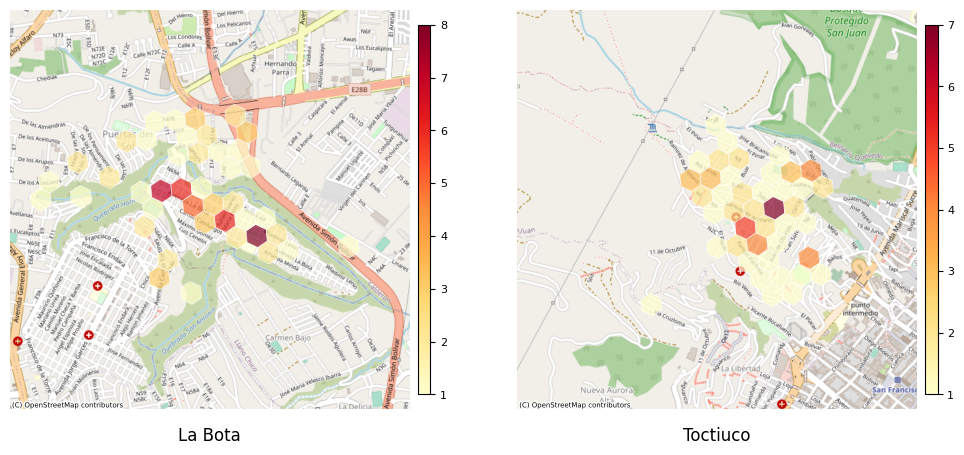

In [62]:
# Create the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
ax = axs[0]

# Set the x and y axis limits
ax.set_xlim(min_lon_BOTA, max_lon_BOTA)
ax.set_ylim(min_lat_BOTA, max_lat_BOTA)

# Plot the data (only boundaries in this case)
hexabins_pois_Bota.plot(ax=ax, column='poi_count', cmap='YlOrRd', edgecolor='white', linewidth=0.5, alpha=0.7,
                        legend=True, legend_kwds={'orientation': "vertical", 'shrink': 0.8, 'aspect': 30, 'fraction': 0.035, 'pad': 0.02})

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('La Bota', loc='center', y=-0.1)
cbar = plt.gcf().get_axes()[-1]
cbar.tick_params(labelsize=8)

ax = axs[1]

# Set the x and y axis limits
ax.set_xlim(min_lon_TOC, max_lon_TOC)
ax.set_ylim(min_lat_TOC, max_lat_TOC)

# Plot the data (only boundaries in this case)
hexabins_pois_Toctiuco.plot(ax=ax, column='poi_count', cmap='YlOrRd', edgecolor='white', linewidth=0.5, alpha=0.7,
                        legend=True, legend_kwds={'orientation': "vertical", 'shrink': 0.8, 'aspect': 30, 'fraction': 0.035, 'pad': 0.02})

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('Toctiuco', loc='center', y=-0.1)

cbar = plt.gcf().get_axes()[-1]
cbar.tick_params(labelsize=8)


In [63]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/H3pois_heatmap.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/H3pois_heatmap.jpg', dpi=300, format='jpeg', bbox_inches='tight')